<a href="https://colab.research.google.com/github/HarounH/smol/blob/main/rl/policy_gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
# @title Install dependencies
!pip install rarfile
!pip install ale-py
!pip install -q gymnasium
!pip install swig
!pip install pyvirtualdisplay
!pip install pyglet
!pip install pygame
!pip install minigrid
!pip install -q swig
!pip install minigrid
!pip3 install box2d-py

In [64]:
# @title Environment Set up and Rendering

import gymnasium
import numpy as np
from collections import deque
from dataclasses import dataclass
import io
import base64
import optax

import numpy as np
import imageio.v2 as imageio
from IPython.display import HTML
import jax.numpy as jnp
from flax import struct
import jax

from IPython.display import HTML
import numpy as np
import imageio
import io, base64
from PIL import Image, ImageDraw, ImageFont
import time
from scipy.ndimage.filters import gaussian_filter1d
import orbax.checkpoint as ocp
from flax import nnx
from IPython.display import clear_output


@struct.dataclass
class Datum:
    s_t: jax.Array
    s_tp1: jax.Array
    r_t: jax.Array
    a_t: jax.Array
    logp_a_t: jax.Array | None
    done: bool
    on_policy_t: bool
    frame_hwc: np.ndarray | None = None


def show_mp4_from_frames_imageio(
    trajectory: list[Datum],
    text_color=(255, 0, 0), # red
    text_padding=10,
    fps=30,
):
    """
    Display a list of (H, W, 3) RGB frames inline as MP4 with optional per-frame text.

    Args:
        frames: list of frames, each (H, W, 3), RGB.
        fps: frames per second.
        text: either a single string or list of strings (len == len(frames)).
        text_color: RGB tuple for text.
        text_padding: pixels offset from top-right corner.

    Returns:
        IPython.display.HTML object.
    """
    frames = [d.frame_hwc for d in trajectory if d.frame_hwc is not None]
    text = [f"a:{d.a_t}" for d in trajectory]
    if not frames:
        raise ValueError("frames list is empty")

    # Normalize text argument
    if text is None:
        texts = [None] * len(frames)
    elif isinstance(text, str):
        texts = [text] * len(frames)
    else:
        if len(text) != len(frames):
            raise ValueError("text list must be same length as frames")
        texts = text

    norm_frames = []
    for idx, f in enumerate(frames):
        f = np.asarray(f)

        if f.ndim != 3 or f.shape[-1] != 3:
            raise ValueError(f"Frame must be (H,W,3), got {f.shape}")

        # Normalize dtype → uint8
        if f.dtype != np.uint8:
            if np.issubdtype(f.dtype, np.floating):
                f = np.clip(f, 0.0, 1.0)
                f = (f * 255).astype(np.uint8)
            else:
                f = np.clip(f, 0, 255).astype(np.uint8)

        # Convert to PIL for text overlay
        img = Image.fromarray(f)
        draw = ImageDraw.Draw(img)

        txt = texts[idx]
        if txt:
            # Choose a default font
            try:
                font = ImageFont.truetype("DejaVuSans.ttf", 20)
            except:
                font = ImageFont.load_default()

            # Width via textlength
            tw = draw.textlength(txt, font=font)
            # Height via font metrics
            ascent, descent = font.getmetrics()
            th = ascent + descent
            # Position: top-right
            H, W = f.shape[:2]
            x = W - tw - text_padding
            y = text_padding

            draw.text((x, y), txt, fill=text_color, font=font)

        norm_frames.append(np.asarray(img))

    # Encode MP4 into an in-memory buffer
    buf = io.BytesIO()
    imageio.mimsave(buf, norm_frames, format="mp4", fps=fps)
    buf.seek(0)
    video_bytes = buf.read()

    b64 = base64.b64encode(video_bytes).decode("ascii")

    html = f"""
    <video controls loop>
        <source src="data:video/mp4;base64,{b64}" type="video/mp4">
        Your browser does not support the video tag.
    </video>
    """
    return HTML(html)

/tmp/ipython-input-2370825611.py:24: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


In [68]:

env = gymnasium.make("LunarLander-v3", render_mode="rgb_array", continuous=False)
def play(
    policy_model,
    exploration_probability: float,
    env,
    current_state,
    rng,
    greedy: bool = True,
    render: bool = False,
) -> tuple[Datum, np.ndarray]:
    action = env.action_space.sample()
    logp_a_t = None
    on_policy_t = False
    if (policy_model is not None):
        if (jax.random.bernoulli(rng.params(), exploration_probability, shape=None)):
            pass
        else:
            pi_a = policy_model(current_state)
            logp_a_t = pi_a
            if greedy:
                action = pi_a.argmax()
            else:
                action = jax.random.categorical(rng.params(), pi_a)
            action = int(action)
            on_policy_t = True

    frame_hwc = env.render() if render else None
    new_state, reward, t0, t1, _ = env.step(action)
    done = (t0 or t1)
    datum = Datum(
        s_t=current_state,
        s_tp1=new_state,
        r_t=reward,
        a_t=action,
        logp_a_t=logp_a_t,
        done=done,
        on_policy_t=on_policy_t,
        frame_hwc=frame_hwc,
    )
    return datum, new_state


def demo(model=None, n_steps: int = 100):
    trajectory = []
    rngs = nnx.Rngs(default=1337)
    state, _ = env.reset()
    for step_idx in range(n_steps):
        datum, state = play(model, 0.0, env, state, rngs, greedy=False, render=True)
        trajectory.append(datum)
    return trajectory

show_mp4_from_frames_imageio(demo(None, n_steps=1000))

/usr/lib/python3.12/subprocess.py:1885: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _fork_exec(


In [66]:
# @title Model

class Layer(nnx.Module):
    def __init__(self, dim: int, rngs: nnx.Rngs):
        self.fc1 = nnx.Linear(dim, dim, rngs=rngs)

    def __call__(self, x):
        z = self.fc1(x)
        z = jax.nn.relu(z)
        return z


class PolicyNetwork(nnx.Module):
    # same shape and stuff as QNet
    def __init__(self, dim_in: int = 4, d_model: int = 32, num_actions: int = 2, num_layers: int = 2, rngs: nnx.Rngs | None = None):
        self.in_proj = nnx.Linear(dim_in, d_model, rngs=rngs)
        self.out_proj = nnx.Linear(d_model, num_actions, rngs=rngs)
        self.layers = [Layer(d_model, rngs) for _layer_idx in range(num_layers)]

    def __call__(self, x):
        z = self.in_proj(x)
        z = jax.nn.relu(z)
        for layer in self.layers:
            z = layer(z)
        z = self.out_proj(z)
        return z




In [9]:
import jax
import jax.numpy as jnp
import numpy as np

class Memory:
    def __init__(self, max_size: int = 1000):
        self.data = None
        self.max_size = max_size

    def extend(self, item):
        if self.data is None:
            self.data = item
        else:
            self.data = jnp.concatenate((self.data, item))
        self.data = self.data[-self.max_size:]

    def sample(self, batch_size: int = 4):
        indices = np.random.randint(0, len(self.data), batch_size)
        return jnp.array([self.data[idx] for idx in indices])
key = jax.random.PRNGKey(0)
key1, key2 = jax.random.split(key, 2)

_memory = Memory(4)
x = jax.random.normal(key1, shape=(4, 5))
_memory.extend(x)
y = jax.random.normal(key2, shape=(4, 5))
_memory.extend(y)

print(_memory.data)
print(_memory.sample(3))

[[-2.4424558  -2.0356805   0.20554423 -0.3535502  -0.76197404]
 [-1.1785518  -1.1482196   0.29716578 -1.3105359   2.1302025 ]
 [-0.18957235  0.96401215 -1.3011001  -0.7486938  -0.3729984 ]
 [ 0.4427907  -1.1902995  -0.06925564 -0.95605886 -1.9587638 ]]
[[-0.18957235  0.96401215 -1.3011001  -0.7486938  -0.3729984 ]
 [-2.4424558  -2.0356805   0.20554423 -0.3535502  -0.76197404]
 [-0.18957235  0.96401215 -1.3011001  -0.7486938  -0.3729984 ]]


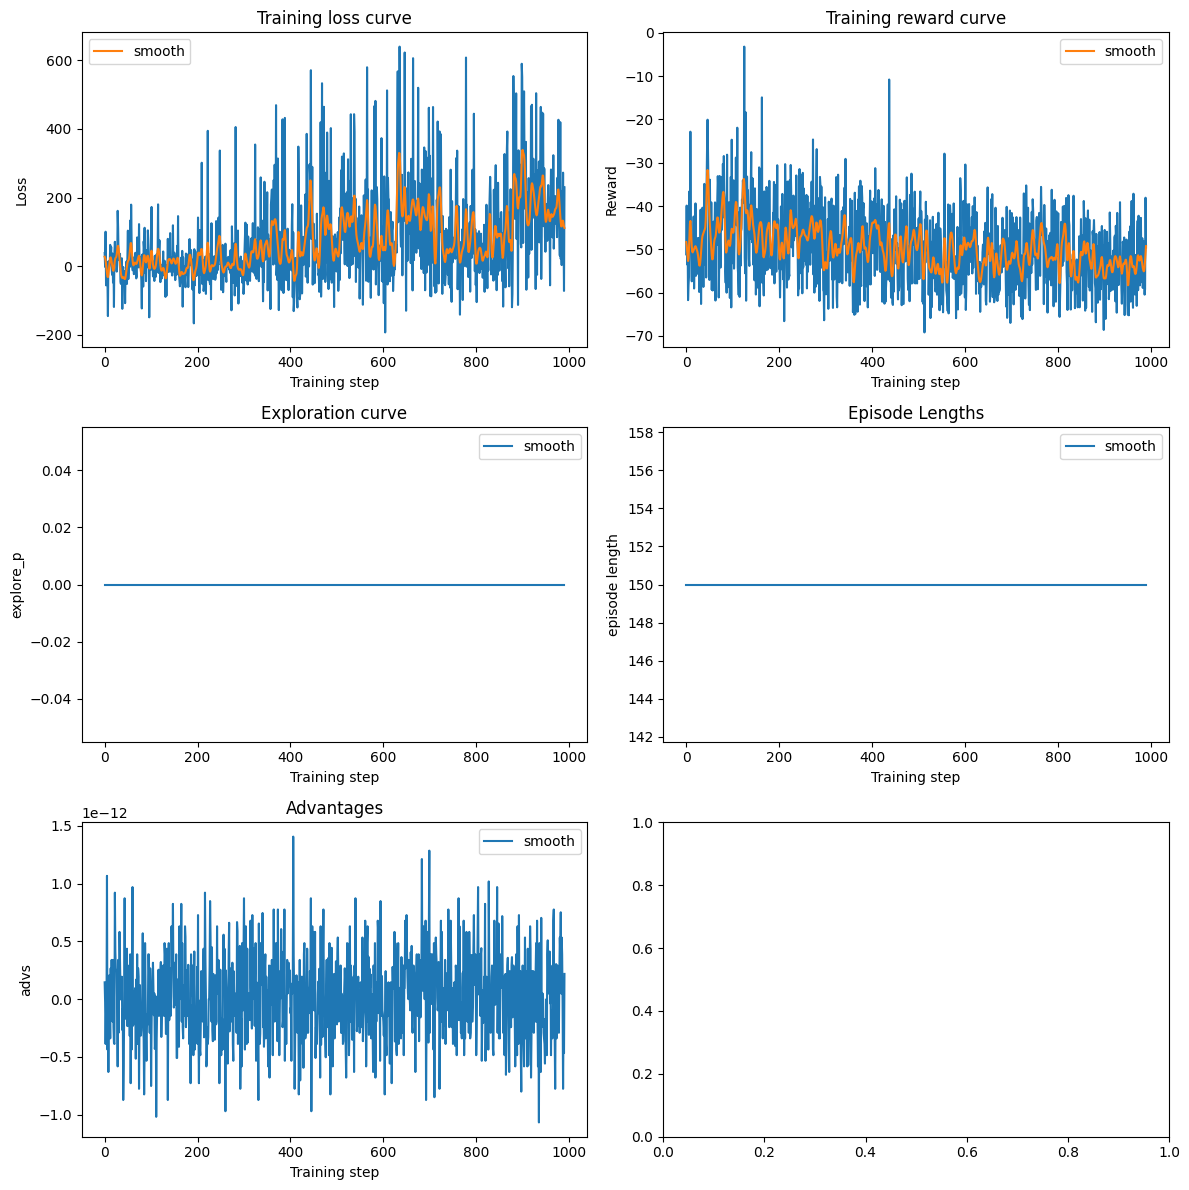

In [69]:
# @title Policy gradients - REINFORCE
"""
J(\theta) = \mathbb{E}_{\tau~\pi}[reward(\tau)]

after taking gradient, we get this interesting form:
\grad_{\theta} J(\theta) = \mathbb{E}_{\tau~\pi}[Q(s, a) \grad ln(\pi(a | s))]
"""

from dataclasses import dataclass, field
import matplotlib.pyplot as plt
import seaborn as sns


@struct.dataclass
class HParams:
    num_training_episodes: int
    max_episode_length: int = 150

    seed: int = 1337
    explore_start = 0.0            # exploration probability at start
    explore_stop = 0.0            # minimum exploration probability
    decay_rate = 0.001            # exponential decay rate for exploration prob

    plot_interval: int = 10
    discount_rate: float = 0.99

    d_model: int = 128
    n_layers: int = 1
    lr: float = 1e-4

    replay_buffer_size = 128
    ckpt_dir: str = '/tmp/checkpoints/'

@struct.dataclass
class TensorTrajectory:
    s_t_TD: jax.Array
    s_tp1_TD: jax.Array
    r_t_T: jax.Array
    a_t_T: jax.Array
    done_t_T: jax.Array
    logpa_t_TA: jax.Array


@dataclass
class State:
    update_idx: int
    losses: list[float] = field(default_factory=list)
    rewards: list[float] = field(default_factory=list)
    explore_ps: list[float] = field(default_factory=list)
    episode_lengths: list[int] = field(default_factory=list)
    advs: list[int] = field(default_factory=list)

params = HParams(
    num_training_episodes=1000,
    # explore_start=0.0,
    # explore_stop=0.0,
)
rngs = nnx.Rngs(default=params.seed)
num_actions = env.action_space.n
dim_in = env.observation_space.shape[0]

policy_model = PolicyNetwork(dim_in, params.d_model, num_actions, params.n_layers, rngs)
optimizer = nnx.Optimizer(policy_model, optax.adamw(params.lr), wrt=nnx.Param)
ckpt_dir = ocp.test_utils.erase_and_create_empty(params.ckpt_dir)
checkpointer = ocp.StandardCheckpointer()
memory = Memory(params.replay_buffer_size)
state = State(update_idx=0)


def done_fn(state: State, params: HParams):
    return (state.update_idx >= params.num_training_episodes)



@struct.dataclass
class Batch:
    s_t_BD: np.ndarray
    a_t_B: np.ndarray
    r_t_B: np.ndarray
    g_t_B: np.ndarray | None

    def to_tensor(self):
        return jnp.concatenate(
            (self.s_t_BD, self.a_t_B.reshape(-1, 1), self.r_t_B.reshape(-1, 1), self.g_t_B.reshape(-1, 1)),
            axis=1,
        )

    @classmethod
    def from_tensor(cls, tensor):
        Dp3 = tensor.shape[1]
        cls(
            s_t_BD=tensor[:, :Dp3-3],
            a_t_B=tensor[:, Dp3-3].astype("int32"),
            r_t_B=tensor[:, Dp3-2],
            g_t_B=tensor[:, Dp3-1],
        )


def compute_g(rewards: list[float], discount_rate: float) -> list[float]:
    g = 0
    g_t_B = []
    for r in rewards[::-1]:
        g = r + discount_rate * g
        g_t_B.append(g)

    g_t_B = np.array(g_t_B[::1])
    g_t_B = (g_t_B - g_t_B.mean())

    return g_t_B


def collate(params: HParams, trajectory: list[Datum]) -> Batch:
    states = []
    actions = []
    rewards = []
    for d in trajectory:
        states.append(d.s_t)
        rewards.append(d.r_t)
        actions.append(d.a_t)

    g = compute_g(rewards,  params.discount_rate)
    states = np.array(states)
    rewards = np.array(rewards)
    actions = np.array(actions)
    return Batch(
        s_t_BD=states,
        r_t_B=rewards,
        a_t_B=actions,
        g_t_B=g,
    )


def unroll(params, env, model, explore_p: float) -> TensorTrajectory:
    trajectory = []
    state, _ = env.reset()
    for step in range(params.max_episode_length):
        datum, state = play(model, explore_p, env, state, rngs, greedy=False, render=False)
        trajectory.append(datum)
    return collate(params, trajectory)

# train loop
def loss_fn(model, s_t_D, a_t, g_t):
    logits = model(s_t_D)
    logp = jax.nn.log_softmax(logits)
    logp_a_t = logp[a_t]
    return -logp_a_t * g_t

batched_loss_fn = jax.vmap(loss_fn, in_axes=(None, 0, 0, 0))

for update_idx in range(params.num_training_episodes):
    explore_p = params.explore_stop + (params.explore_start - params.explore_stop) * np.exp(-params.decay_rate * update_idx)
    unrolled_batch = unroll(params, env, policy_model, explore_p)
    unrolled_batch_tensor = unrolled_batch.to_tensor()
    memory.extend(unrolled_batch_tensor)
    batch = Batch.from_tensor(memory.sample(unrolled_batch_tensor.shape[0]))

    # print(jax.tree.map(lambda x: x.shape, batch, is_leaf=lambda x: isinstance(x, np.ndarray)))

    def closure(model, rngs_for_closure):
        batch_loss = batched_loss_fn(model, batch.s_t_BD, batch.a_t_B, batch.g_t_B)
        return batch_loss.mean()

    (loss, grads) = nnx.value_and_grad(closure)(policy_model, rngs)
    optimizer.update(grads)

    state.losses.append(float(loss))
    state.rewards.append(float(batch.r_t_B.mean()))
    state.advs.append(float(batch.g_t_B.mean()))
    state.explore_ps.append(float(explore_p))
    state.episode_lengths.append(int(batch.s_t_BD.shape[0]))
    state.update_idx = update_idx
    done = done_fn(state, params)

    if done or update_idx % params.plot_interval == 0:
        clear_output(wait=True)

        # plot losses and rewards
        fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
        axes = axes.flatten()
        sns.lineplot(x=range(len(state.losses)), y=state.losses, ax=axes[0])
        smooth_loss = gaussian_filter1d(state.losses, sigma=2)
        sns.lineplot(x=range(len(state.losses)), y=smooth_loss, ax=axes[0], label="smooth", legend="auto")
        axes[0].set_xlabel("Training step")
        axes[0].set_ylabel("Loss")
        axes[0].set_title("Training loss curve")

        sns.lineplot(x=range(len(state.rewards)), y=state.rewards, ax=axes[1])
        smooth_reward = gaussian_filter1d(state.rewards, sigma=2)
        sns.lineplot(x=range(len(state.rewards)), y=smooth_reward, ax=axes[1], label="smooth", legend="auto")

        axes[1].set_xlabel("Training step")
        axes[1].set_ylabel("Reward")
        axes[1].set_title("Training reward curve")

        sns.lineplot(x=range(len(state.explore_ps)), y=state.explore_ps, ax=axes[2], label="smooth", legend="auto")
        axes[2].set_xlabel("Training step")
        axes[2].set_ylabel("explore_p")
        axes[2].set_title("Exploration curve")


        sns.lineplot(x=range(len(state.episode_lengths)), y=state.episode_lengths, ax=axes[3], label="smooth", legend="auto")
        axes[3].set_xlabel("Training step")
        axes[3].set_ylabel("episode length")
        axes[3].set_title("Episode Lengths")

        sns.lineplot(x=range(len(state.advs)), y=state.advs, ax=axes[4], label="smooth", legend="auto")
        axes[4].set_xlabel("Training step")
        axes[4].set_ylabel("advs")
        axes[4].set_title("Advantages")

        plt.tight_layout()
        plt.show()

    if done:
        break


In [70]:
show_mp4_from_frames_imageio(demo(policy_model, n_steps=150))

/usr/lib/python3.12/subprocess.py:1885: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _fork_exec(
